In [1]:
import gc
gc.collect()

26

In [2]:
# Import comet_ml at the top of your file
# from comet_ml import Experiment


from matplotlib import pyplot as plt
# from matplotlib import style
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import swifter
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import itertools
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
from sklearn.model_selection import train_test_split
import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
# import spacy 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras as k
import tensorflow as tf
# import torch
from scipy import stats
import seaborn as sns
from numpy.random import seed

lemmatizer = WordNetLemmatizer()
scaler = MinMaxScaler(feature_range=(0, 1))

# Create an experiment with your api key
# experiment = Experiment(
#     api_key="BKac2uRt0FMAlheXf6HClaZhD",
#     project_name="general",
#     workspace="sarthak7034",
# )


2022-05-15 12:46:33.970696: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-15 12:46:33.970727: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
nltk.download('stopwords')
stop_words = stopwords.words('english') 
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/users/s/sarthak_7034/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/users/s/sarthak_7034/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/users/s/sarthak_7034/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('gpu')))
# torch.cuda.is_available()

Num GPUs Available:  0


2022-05-15 01:03:10.160475: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-15 01:03:10.160513: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-15 01:03:10.160535: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (frontend01): /proc/driver/nvidia/version does not exist


In [6]:
# # Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)


# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
    
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, cm[i, j],
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')

In [7]:
# experiment.end()

In [8]:
#Read dataset
data = pd.read_csv("./all_data.csv").drop("Unnamed: 0", axis=1)

## Cleaning Text

In [3]:
# nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def clean_text(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    
    # tokens = [token.lower() for token in tokens]          #decrease the accuracy %
    # doc = nlp(text)
    # tokens = [token.lemma_ for token in doc]                 #Spacey
    #Tokenize
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    # remove stopwords
    tokens = [w for w in tokens if not w in stop_words]     # Experiment with removing it!!!

    #Lemmatize
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    #Remove non alphanumerica characters
    words = [word for word in tokens if word.isalpha()]    

    return words


In [10]:
#Applying lamdba function to clean text
data['text'] = data.swifter.apply(lambda row: clean_text(row['text']), axis=1)
#Clean title
data['title'] = data.swifter.apply(lambda row: clean_text(row['title']), axis=1)


Pandas Apply:   0%|          | 0/20015 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/20015 [00:00<?, ?it/s]

In [11]:
#Replacing row with only text
data = data[data['title'].str.len() >= 1]
data = data[data['text'].str.len() >= 1]

In [12]:
data = data[data['text'].map(len) >= 1]
#Reset index
data = data.reset_index().drop("index", axis=1)

In [13]:
df1 = data.loc[:,['anger','anticipation','disgust','fear','joy','sadness','surprise','trust','negative','positive']]

# # Zero Score Dataframe Normalization
# MaxMin_df = stats.zscore(df1)
# # MaxMin_df = scaler.fit_transform(df1)
# MaxMin_df.head()

In [14]:
#Displaying the new dataset which we will be working with
df2 = data.loc[:,['title','text','type']]

In [15]:
df_merge = pd.concat([df2,df1],axis=1)
df_merge.head()

,title,text,type,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
0,"[At, Donald, Trump, Properties, Showcase, Bran...","[They, stood, line, Trump, Tower, sometimes, h...",real,9,21,5,6,20,5,14,30,14,52
1,"[Trump, Foundation, Tells, New, York, It, Has,...","[Donald, J, Trump, foundation, informed, Attor...",real,6,7,2,4,4,4,5,9,8,15
2,"[Donald, Trump, Prepares, White, House, Move, ...","[President, Donald, J, Trump, White, House, ou...",real,5,19,6,8,15,8,6,26,15,34
3,"[Luring, Chinese, Investors, With, Trump, Name...","[An, investment, pitch, new, Texas, hotel, try...",real,11,14,6,10,10,10,6,32,24,43
4,"[Melania, Barron, Trump, Won, Immediately, Mov...","[President, Donald, J, Trump, wife, Melania, s...",real,1,12,0,3,6,2,4,14,4,25


In [16]:
# Whether any values are missing
# df2.isnull().sum()
# df1.isnull().sum()

type
fake    11731
real     8074
Name: title, dtype: int64


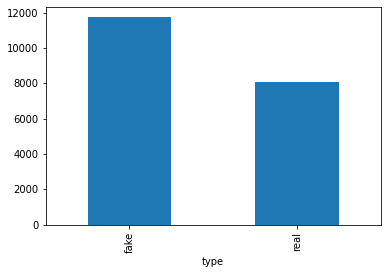

In [17]:
# How many fake and real articles?
print(df_merge.groupby(['type'])['title'].count())
df_merge.groupby(['type'])['title'].count().plot(kind="bar")
plt.show()

## Word2Vec

In [18]:
model_embed = KeyedVectors.load_word2vec_format("./GoogleNews-vectors-negative300.bin.gz",binary=True)

In [19]:
vocab_length = len(model_embed.key_to_index.keys())
print(vocab_length)                                         #Input dimension size(3000000)

3000000


In [20]:
# Applying it to the columns 

df_merge['title'] = df_merge.swifter.apply(lambda r: [model_embed.key_to_index[x] for x in r['title'] if x in model_embed.key_to_index], axis=1)
df_merge['text'] = df_merge.swifter.apply(lambda r: [model_embed.key_to_index[x] for x in r['text'] if x in model_embed.key_to_index], axis=1)

Pandas Apply:   0%|          | 0/19805 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/19805 [00:00<?, ?it/s]

In [21]:
# # One-hot encoding
# encoder = LabelBinarizer().fit(list(df2['type']))
# df2['type'] = df2.swifter.apply(lambda r: encoder.transform([r['type']])[0], axis=1)

variable_name = {'fake' : 0 , 'real' : 1 }
df_merge['type'] = df_merge['type'].map(variable_name)

In [22]:
df_merge = df_merge[df_merge['text'].map(len) >= 1]
#Reset index
df_merge = df_merge.reset_index().drop("index", axis=1)
df_merge.shape

(19672, 13)

In [23]:
# Shifting all to a new dataframe
df3 = df_merge.loc[:,['title','text','type','anger','anticipation','disgust','fear','joy','sadness','surprise','trust','negative','positive']]

In [24]:
# Check the highest length of text and title:
max_tokens_text = 13000
max_tokens_title = 48

## Padding

In [25]:
df3['text'] = list(pad_sequences((df_merge['text']), maxlen=max_tokens_text,padding='post'))
df3['title'] = list(pad_sequences(df_merge['title'], maxlen=max_tokens_title,padding='post'))

In [26]:
df3.shape

(19672, 13)

In [27]:
#Python object serialized
df3.to_pickle('./model_data.pickle')

# Building Model

## Loading Pickle 

In [3]:
data_pickle = pd.read_pickle('./model_data.pickle')
data_pickle = data_pickle.dropna()
data_pickle.head()

,title,text,type,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
0,"[332, 6117, 13034, 11062, 20257, 9193, 446, 0,...","[128, 2379, 318, 13034, 9413, 1631, 242, 957, ...",1,9,21,5,6,20,5,14,30,14,52
1,"[13034, 2124, 44625, 442, 5353, 51, 7754, 8808...","[6117, 4883, 13034, 3113, 2826, 4605, 1927, 33...",1,6,7,2,4,4,4,5,9,8,15
2,"[6117, 13034, 49031, 1790, 659, 11977, 553, 94...","[446, 6117, 4883, 13034, 1790, 659, 16780, 177...",1,5,19,6,8,15,8,6,26,15,34
3,"[176192, 1035, 3789, 316, 13034, 12441, 3337, ...","[741, 615, 1924, 65, 675, 1639, 469, 8793, 112...",1,11,14,6,10,10,10,6,32,24,43
4,"[282726, 14896, 13034, 26994, 17785, 11977, 17...","[446, 6117, 4883, 13034, 783, 282726, 831, 148...",1,1,12,0,3,6,2,4,14,4,25


In [4]:
#Train - test
X_train, X_test, y_train, y_test = train_test_split(
    data_pickle[['text', 'title','anger','anticipation','disgust','fear','joy','sadness','surprise','trust','negative','positive']], data_pickle['type'], test_size=0.2, random_state=42)

#Train - valid
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

In [5]:
dftrain = X_train.iloc[:,2:]
# Zero Score Dataframe Normalization
# MaxMin_df = stats.zscore(df1)
# MaxMin_df.head()
MaxMin_df_train = scaler.fit_transform(dftrain)

In [6]:
dftest = X_test.iloc[:,2:]
MaxMin_df_test = scaler.fit_transform(dftest)

dfvalid = X_valid.iloc[:,2:]
MaxMin_df_valid = scaler.fit_transform(dfvalid)

In [7]:
# Check the highest length of text and title:
max_tokens_text = 13000
max_tokens_title = 48

In [8]:
train_fit = [np.asarray(X_train['title'].tolist()), 
             np.asarray(X_train['text'].tolist()),
            MaxMin_df_train
            ]

test_fit = [np.asarray(X_test['title'].tolist()), 
             np.asarray(X_test['text'].tolist()),
            MaxMin_df_test
            ]    

valid_fit = [np.asarray(X_valid['title'].tolist()), 
             np.asarray(X_valid['text'].tolist()),
            MaxMin_df_valid
            ]



## LSTM

In [30]:
seed(50)
tf.random.set_seed(50)
k.backend.clear_session()

In [31]:
#input_title
title_input = k.layers.Input(shape=(max_tokens_title,))
inp = k.layers.Embedding(input_dim=3000000,output_dim=300,trainable=False)(title_input)
x1 = k.layers.Bidirectional(k.layers.LSTM(50))(inp)


#input_Text
content_input = k.layers.Input(shape=(max_tokens_text,))
inp2 = k.layers.Embedding(input_dim=3000000,output_dim=300,trainable=False)(content_input)
x2 = k.layers.Bidirectional(k.layers.LSTM(200))(inp2)

#input_sentiments
x3 = k.layers.Input(shape=(10,))


#Merge
x = k.layers.concatenate([x1, x2, x3])


#Common part
x = k.layers.Dense(50, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)

out = k.layers.Dense(1, activation='sigmoid')(x)

#Build model
baseline_model = k.models.Model(inputs=[title_input, content_input,x3], outputs=[out])
baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

baseline_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 13000)]      0           []                               
                                                                                                  
 embedding (Embedding)          (None, 48, 300)      900000000   ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 13000, 300)   900000000   ['input_2[0][0]']                
                                                                                              

In [32]:
history = baseline_model.fit(x=train_fit, y=np.asarray(y_train.tolist()), batch_size = 64,
        callbacks = [k.callbacks.EarlyStopping(monitor='val_loss', patience=3,min_delta = 0.1)], 
                            validation_data=(valid_fit, np.array(y_valid.tolist())), epochs = 2)

Epoch 1/2
197/197 [==============================] - 4383s 22s/step - loss: 0.5033 - acc: 0.7481 - val_loss: 0.3561 - val_acc: 0.8323
Epoch 2/2
197/197 [==============================] - 4370s 22s/step - loss: 0.2885 - acc: 0.8770 - val_loss: 0.2816 - val_acc: 0.8796


In [33]:
test_pred = baseline_model.predict(test_fit)

In [34]:
report = classification_report(np.array(y_test.tolist()), test_pred.round())
print(report)

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      2354
           1       0.93      0.79      0.85      1581

    accuracy                           0.89      3935
   macro avg       0.90      0.88      0.88      3935
weighted avg       0.90      0.89      0.89      3935



In [36]:
print("The accuracy for testing data is", np.mean(test_pred.round() == np.array(y_test.tolist())))

The accuracy for testing data is 0.5310763050782329


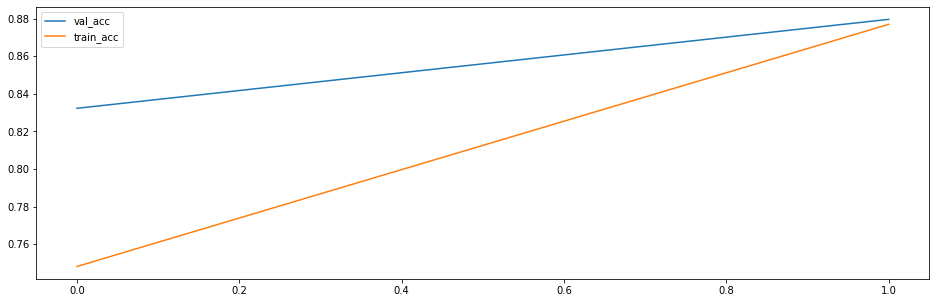

In [37]:
plt.figure(figsize=(16,5))
plt.plot(history.history['val_acc'], label='val_acc')
plt.plot(history.history['acc'], label='train_acc')
plt.legend()

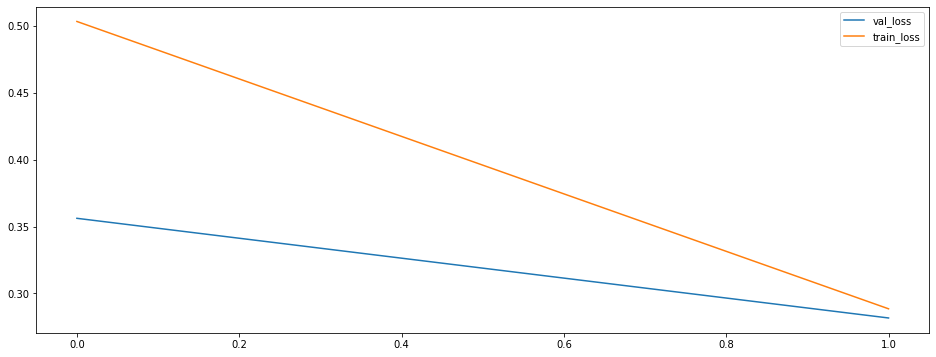

In [38]:
plt.figure(figsize=(16,6))
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label='train_loss')
plt.legend()

[[2259   95]
 [ 331 1250]]


<AxesSubplot:>

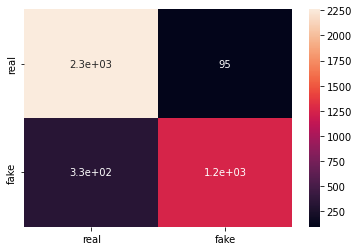

In [39]:
matrix = confusion_matrix(np.array(y_test.tolist()), test_pred.round())
print(matrix)

df_cm = pd.DataFrame(matrix, columns=['real', 'fake'], index=['real', 'fake'])
sns.heatmap(df_cm, annot=True)

## Binary_crossentropy

In [40]:
seed(50)
tf.random.set_seed(50)
k.backend.clear_session()

In [41]:
#input_title
title_input = k.layers.Input(shape=(max_tokens_title,))
inp1 = k.layers.Embedding(input_dim=3000000,output_dim=300,trainable=False)(title_input)

x1 = k.layers.Conv1D(filters = 32, kernel_size=4, strides=2, activation='relu')(inp1)
x1 = k.layers.MaxPool1D(pool_size = 2)(x1)
x1 = k.layers.Flatten()(x1)
x1 = k.layers.Dense(50, activation='relu', kernel_regularizer='l2')(x1)


#input_Text
text_input = k.layers.Input(shape=(max_tokens_text,))
inp2 = k.layers.Embedding(input_dim=3000000,output_dim=300,trainable=False)(text_input)


x2 = k.layers.Conv1D(filters = 64, kernel_size = 4, strides = 2, activation='relu')(inp2)
x2 = k.layers.MaxPool1D(pool_size = 4)(x2)


x2 = k.layers.Flatten()(x2)
x2 = k.layers.Dense(100, activation='relu', kernel_regularizer='l2')(x2)


#Sentiments-------------------------------------------------------------------------------------------------------

sentiment_input = k.layers.Input(shape=(10,))
x3 = k.layers.Flatten()(sentiment_input)
x3= k.layers.Dense(10, activation='relu', kernel_regularizer='l2')(x3)

#Merge-------------------------------------------------------------------------------------------------------------
# x = k.layers.concatenate([x1,x2])
x = k.layers.concatenate([x1,x2,x3])
x = k.layers.Dropout(0.2)(x)

#Common part-------------------------------------------------------------------------------------------------------
x = k.layers.Dense(50, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)
out = k.layers.Dense(1, activation='sigmoid')(x)


#Build model
# model = k.models.Model(inputs=[title_input, text_input], outputs=[out])
model1 = k.models.Model(inputs=[title_input, text_input,sentiment_input], outputs=[out])
model1.compile(k.optimizers.RMSprop(), loss='binary_crossentropy', metrics=['acc'])

model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 13000)]      0           []                               
                                                                                                  
 embedding (Embedding)          (None, 48, 300)      900000000   ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 13000, 300)   900000000   ['input_2[0][0]']                
                                                                                              

## Fitting the Model

In [42]:
history = model1.fit(x=train_fit, y=np.asarray(y_train.tolist()), batch_size=128, epochs=30,
        callbacks = [k.callbacks.EarlyStopping(monitor='val_loss', patience=3,min_delta = 0.1)], 
        validation_data=(valid_fit, np.array(y_valid.tolist()))
        )

Epoch 1/30
99/99 [==============================] - 216s 2s/step - loss: 1.0228 - acc: 0.7175 - val_loss: 0.5957 - val_acc: 0.8110
Epoch 2/30
99/99 [==============================] - 214s 2s/step - loss: 0.5375 - acc: 0.8312 - val_loss: 0.5549 - val_acc: 0.8088
Epoch 3/30
99/99 [==============================] - 213s 2s/step - loss: 0.4330 - acc: 0.8710 - val_loss: 0.4419 - val_acc: 0.8523
Epoch 4/30
99/99 [==============================] - 214s 2s/step - loss: 0.3631 - acc: 0.8997 - val_loss: 0.3325 - val_acc: 0.9095
Epoch 5/30
99/99 [==============================] - 213s 2s/step - loss: 0.3613 - acc: 0.9121 - val_loss: 0.3170 - val_acc: 0.9136
Epoch 6/30
99/99 [==============================] - 215s 2s/step - loss: 0.2851 - acc: 0.9365 - val_loss: 0.3220 - val_acc: 0.9133
Epoch 7/30
99/99 [==============================] - 215s 2s/step - loss: 0.2486 - acc: 0.9498 - val_loss: 0.2573 - val_acc: 0.9336


In [43]:
test_pred = model1.predict(test_fit)

In [44]:
report = classification_report(np.array(y_test.tolist()), test_pred.round())
print(report)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2354
           1       0.94      0.91      0.92      1581

    accuracy                           0.94      3935
   macro avg       0.94      0.93      0.94      3935
weighted avg       0.94      0.94      0.94      3935



In [45]:
print("The accuracy for testing data is", np.mean(test_pred.round() == np.array(y_test.tolist())))

The accuracy for testing data is 0.5218906984366347


In [46]:
print("The accuracy for training data is", np.mean(model1.predict(train_fit) == np.array(y_train.tolist())) )

The accuracy for training data is 0.0


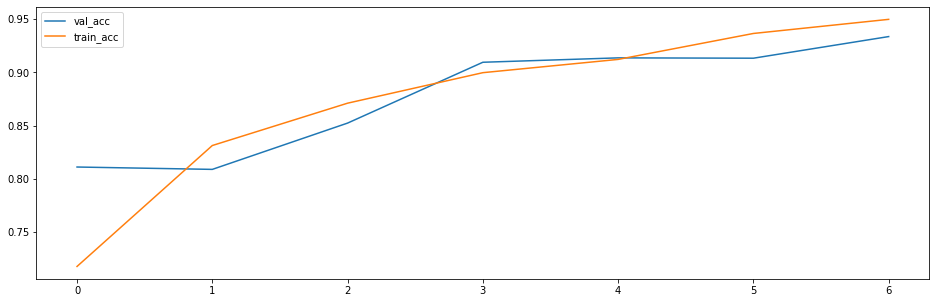

In [47]:
plt.figure(figsize=(16,5))
plt.plot(history.history['val_acc'], label='val_acc')
plt.plot(history.history['acc'], label='train_acc')
plt.legend()

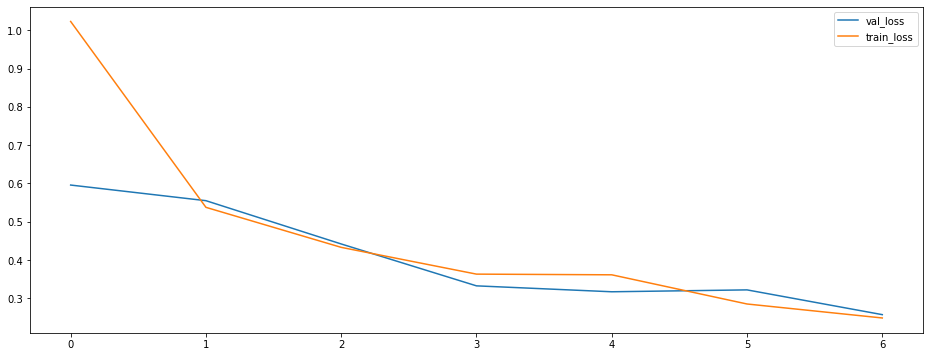

In [48]:
plt.figure(figsize=(16,6))
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label='train_loss')
plt.legend()

[[2258   96]
 [ 148 1433]]


<AxesSubplot:>

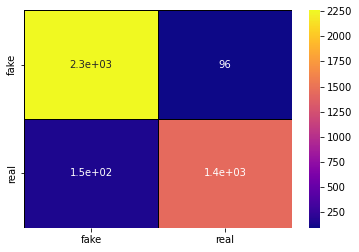

In [49]:
matrix = confusion_matrix(np.array(y_test.tolist()), test_pred.round())
print(matrix)

df_cm = pd.DataFrame(matrix, columns=['fake', 'real'], index=['fake', 'real'])
sns.heatmap(df_cm, annot=True,cmap ='plasma', linecolor ='black', linewidths = 1)

## Categorical_crossentropy

In [50]:
from numpy.random import seed

seed(50)
tf.random.set_seed(50)
k.backend.clear_session()

In [51]:
#input_title
title_input = k.layers.Input(shape=(max_tokens_title,))
inp1 = k.layers.Embedding(input_dim=3000000,output_dim=300,trainable=False)(title_input)

x1 = k.layers.Conv1D(filters = 32, kernel_size=4, strides=2, activation='relu')(inp1)
x1 = k.layers.MaxPool1D(pool_size = 2)(x1)
x1 = k.layers.Flatten()(x1)
x1 = k.layers.Dense(50, activation='relu',  kernel_regularizer='l2')(x1)

#input_content
text_input = k.layers.Input(shape=(max_tokens_text,))
inp2 = k.layers.Embedding(input_dim=3000000,output_dim=300,trainable=False)(text_input)

x2 = k.layers.Conv1D(filters = 64, kernel_size = 4, strides = 2, activation='relu')(inp2)
x2 = k.layers.MaxPool1D(pool_size = 4 )(x2)

#Added
# x2 = k.layers.Conv1D(filters = 80, kernel_size = 16, strides = 4, activation='relu')(inp2)
# x2 = k.layers.MaxPool1D(pool_size = 4, )(x2)
x2 = k.layers.Flatten()(x2)
x2 = k.layers.Dense(100, activation='relu', kernel_regularizer='l2')(x2)

sentiment_input = k.layers.Input(shape=(10,))
x3 = k.layers.Flatten()(sentiment_input)
x3= k.layers.Dense(10, activation='relu', kernel_regularizer='l2')(x3)


#Merge
# x = k.layers.concatenate([x1, x2])
x = k.layers.concatenate([x1,x2,x3])
x = k.layers.Dropout(0.2)(x)

#Common part
# x = k.layers.Dense(50, activation='relu')(x)
# x = k.layers.Dropout(0.2)(x)
x = k.layers.Dense(50, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)
out = k.layers.Dense(5, activation='softmax')(x)


#Build model
# model = k.models.Model(inputs=[title_input, text_input], outputs=[out])
model2 = k.models.Model(inputs=[title_input, text_input,sentiment_input], outputs=[out])
model2.compile(k.optimizers.RMSprop(), loss='sparse_categorical_crossentropy', metrics=['acc'])

model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 13000)]      0           []                               
                                                                                                  
 embedding (Embedding)          (None, 48, 300)      900000000   ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 13000, 300)   900000000   ['input_2[0][0]']                
                                                                                              

## Fitting the Model

In [52]:
history = model2.fit(x=train_fit, y=np.asarray(y_train.tolist()), batch_size=128, epochs=30,
        callbacks = [k.callbacks.EarlyStopping(monitor='val_loss', patience=3,min_delta = 0.1)], 
        validation_data=(valid_fit, np.array(y_valid.tolist())))

Epoch 1/30
99/99 [==============================] - 217s 2s/step - loss: 1.2145 - acc: 0.6533 - val_loss: 0.7118 - val_acc: 0.7519
Epoch 2/30
99/99 [==============================] - 213s 2s/step - loss: 0.6193 - acc: 0.8053 - val_loss: 0.5152 - val_acc: 0.8339
Epoch 3/30
99/99 [==============================] - 214s 2s/step - loss: 0.4877 - acc: 0.8519 - val_loss: 0.4516 - val_acc: 0.8590
Epoch 4/30
99/99 [==============================] - 214s 2s/step - loss: 0.4061 - acc: 0.8862 - val_loss: 0.3497 - val_acc: 0.9044
Epoch 5/30
99/99 [==============================] - 214s 2s/step - loss: 0.3560 - acc: 0.9071 - val_loss: 0.3655 - val_acc: 0.8920
Epoch 6/30
99/99 [==============================] - 215s 2s/step - loss: 0.3101 - acc: 0.9218 - val_loss: 0.3097 - val_acc: 0.9171
Epoch 7/30
99/99 [==============================] - 216s 2s/step - loss: 0.2549 - acc: 0.9423 - val_loss: 0.2826 - val_acc: 0.9292


In [53]:
test_pred = model2.predict(test_fit)

In [54]:
#get predicted indices (ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets)
test_pred = np.argmax(test_pred, 1)

In [55]:
report = classification_report(np.array(y_test.tolist()), test_pred.round())
print(report)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2354
           1       0.93      0.90      0.91      1581

    accuracy                           0.93      3935
   macro avg       0.93      0.93      0.93      3935
weighted avg       0.93      0.93      0.93      3935



In [56]:
print("The accuracy for testing data is", np.mean(test_pred.round() == np.array(y_test.tolist())) )
print("The accuracy for training data is", np.mean(np.argmax(model2.predict(train_fit),1) == np.array(y_train.tolist())) )

The accuracy for testing data is 0.9303684879288437
The accuracy for training data is 0.9778377949003098


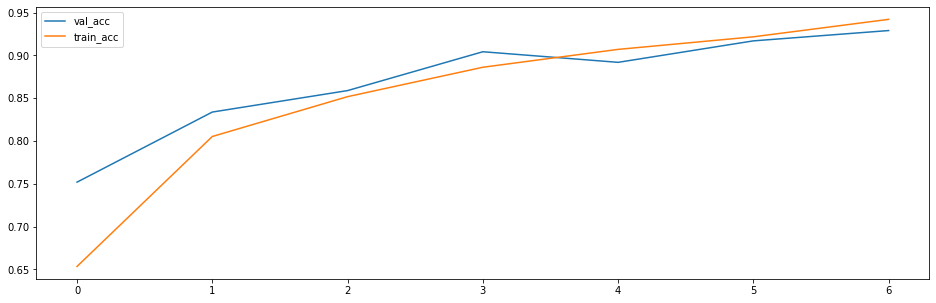

In [57]:
plt.figure(figsize=(16,5))
plt.plot(history.history['val_acc'], label='val_acc')
plt.plot(history.history['acc'], label='train_acc')
plt.legend()

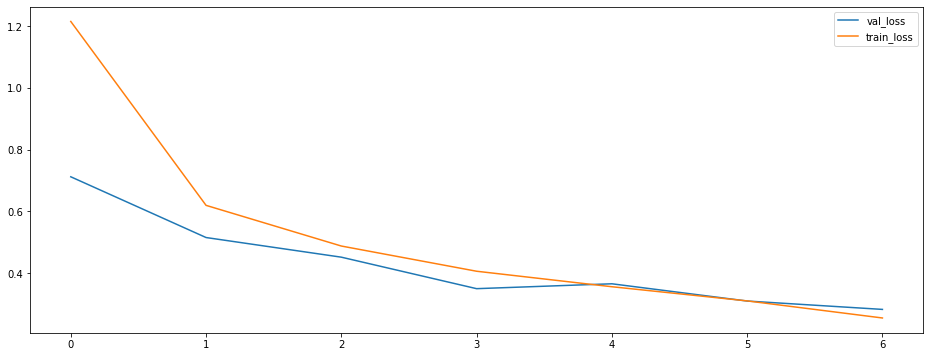

In [58]:
plt.figure(figsize=(16,6))
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label='train_loss')
plt.legend()

[[2239  115]
 [ 159 1422]]


<AxesSubplot:>

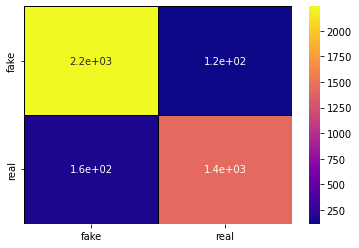

In [59]:
matrix = confusion_matrix(np.array(y_test.tolist()), test_pred.round())
print(matrix)

df_cm = pd.DataFrame(matrix, columns=['fake', 'real'], index=['fake', 'real'])
sns.heatmap(df_cm, annot=True,cmap ='plasma', linecolor ='black', linewidths = 1)